# Import des modules

In [1]:
# imports de modules
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
import shap
import matplotlib.pyplot as plt
import pickle


In [30]:
loaded_model = pickle.load(open("mlruns/0/074a36d72b0647da88c0d2fc34a085b4/artifacts/model/model.pkl", 'rb'))


Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator GridSearchCV from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


# Lecture des données

In [74]:
# Lecture data csv
db = pd.read_csv('1_and_0/1.csv')
db["patient"] = 1
for i in range(2, 17):
    db1 = pd.read_csv('1_and_0/'+str(i)+'.csv')
    db1["patient"] = i
    db = pd.concat([db, db1])
# preprocess step
db.replace([np.inf, -np.inf], 1000, inplace=True)
db.fillna(db.mean(axis=0))
db.dropna(how='any', inplace=True)
db.columns
db.head()


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


12443

In [135]:
db.columns

Index(['interval_index', 'interval_start_time', 'mean_nni', 'sdnn', 'sdsd',
       'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni',
       'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr',
       'lf', 'hf', 'vlf', 'lf_hf_ratio', 'csi', 'cvi', 'Modified_csi',
       'sampen', 'sd1', 'sd2', 'ratio_sd2_sd1', 'timestamp', 'filename',
       'label', 'patient'],
      dtype='object')

In [33]:
# Split du dataset entre train et test sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(db, test_size=0.2, random_state=25)

# élimination des features n'intervenant pas dans la ^rédiction
X_train = train_data.drop('label', axis=1).drop('timestamp', axis=1).drop('patient', axis=1)
X_train = X_train.drop('filename', axis=1)
# séparation de la colonne contenant les label
y_train = train_data['label']
X_test = test_data.drop('label', axis=1).drop('timestamp', axis=1).drop('patient', axis=1)
X_test = X_test.drop('filename', axis=1)
y_test = test_data['label']


# print(X_train.isnull().values.any())
# print(y_train.isnull().values.any())
#result = X_train.dtypes
# print(result)


In [34]:
loaded_model.best_estimator_


RandomForestClassifier(max_depth=14, n_estimators=4)

In [40]:
loaded_model.best_estimator_.score(X_test.values,y_test.values)

0.7556761101064898

In [36]:
len(np.where(loaded_model.best_estimator_.predict(X_test.values)==1)[0])

18

In [37]:
len(np.where(loaded_model.best_estimator_.predict(X_test.values)==1)[0])/len(np.where(y_test.values==1)[0])

0.0297029702970297

# Entraînement d'un random forest

In [10]:
# train et fit la prédiction
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=50)
rf.fit(X_train.values, y_train.values)

pred = rf.predict(X_test.values)
sklearn.metrics.f1_score(y_test, pred, average='binary')


0.9671440606571187

In [11]:
"""Pour utiliser le model de la pipeline"""
rf=loaded_model.best_estimator_

# Explication avec SHAP

In [41]:
shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)


## Explication globale sur tout les patients

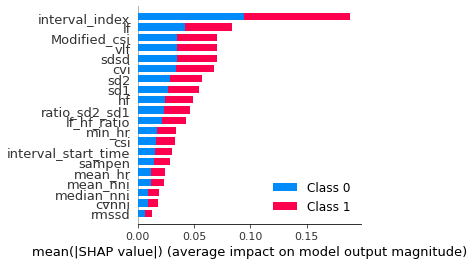

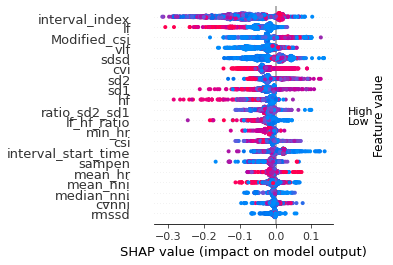

In [122]:
shap.summary_plot(shap_values, X_test.values,
                  plot_type="bar", feature_names=X_test.columns,plot_size=(4,4))


shap.summary_plot(shap_values[1], X_test.values,
                  feature_names=X_test.columns, plot_type="dot",plot_size=(4,4))
# shap.summary_plot(shap_values[1], X_test.values,feature_names=X_test.columns,plot_type="layered_violin")


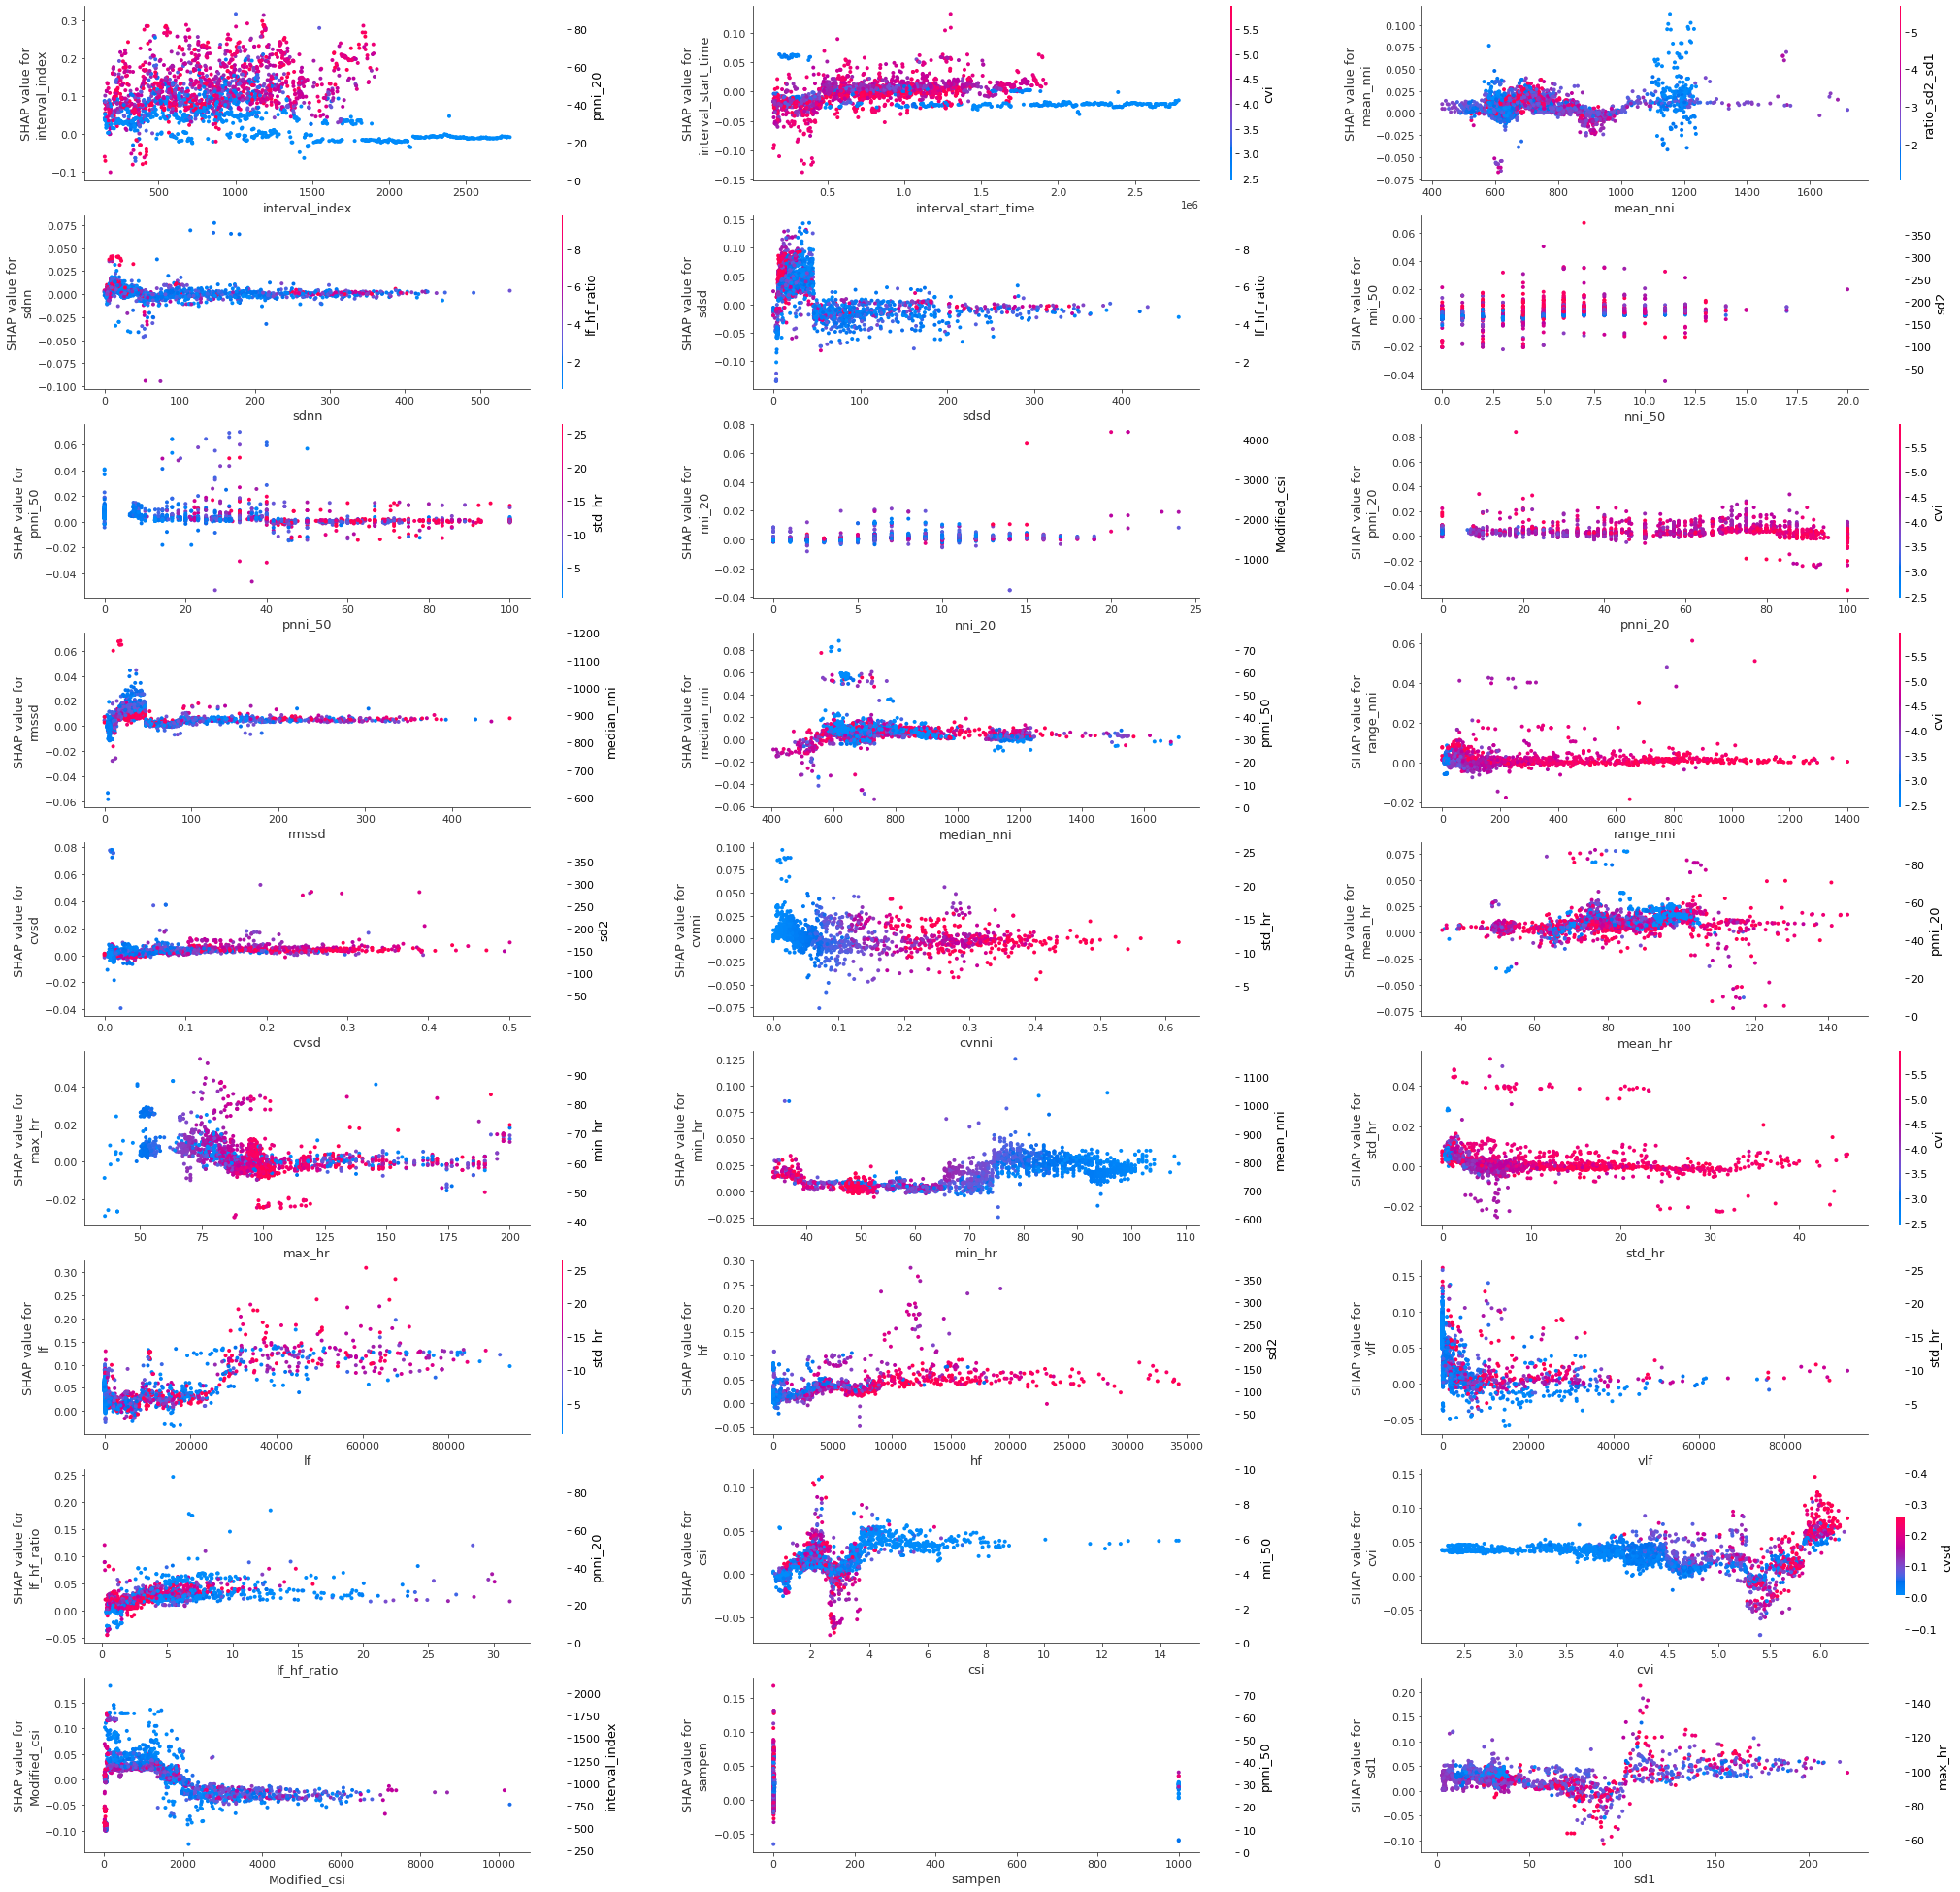

In [44]:
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(35, 35))
axes = axes.ravel()


for i in range(len(X_test.columns)):
    try:
        shap.dependence_plot(
        i, shap_values[0], X_test.values, feature_names=X_test.columns, show=False, ax=axes[i])
    except:
        None
    


In [16]:
# proportion of positive
len(np.where(y_test == 1)[0])/len(y_test)


0.24347127360385698

In [17]:
i = 0



shap.force_plot(explainer.expected_value[0], shap_values[1]
                [i], X_test.values[i], feature_names=X_test.columns)

rf.predict([X_test.values[i]])
y_test.values[i]


0

In [146]:
explainer.expected_value[1]

0.49889630666523094

In [147]:
i = 45
shap.force_plot(explainer.expected_value[0], shap_values[1]
                [i], X_test.values[i], feature_names=X_test.columns)


In [139]:
row = 45
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row],
                                     base_values=explainer.expected_value[0], data=X_test.iloc[row],
                                     feature_names=X_test.columns.tolist()))


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

## Explication pour 1 patient

In [124]:
X = db[db['patient'] == 5].drop('label', axis=1).drop('timestamp', axis=1).drop('patient', axis=1).drop('filename', axis=1)
explainer_patient = shap.TreeExplainer(rf)
shap_values_patient = explainer_patient.shap_values(X)
len(X)

12443

In [125]:
shap_values_patient[0][0]

array([ 0.09459864, -0.02123207, -0.0014603 ,  0.00285538, -0.00865763,
        0.00966774,  0.00402325,  0.00030887,  0.00107934,  0.00448649,
        0.00420208,  0.00176683,  0.00292219,  0.00108209,  0.00735269,
        0.00406398,  0.03077862, -0.00094827,  0.04324727,  0.07742936,
        0.00747034,  0.00700292,  0.00766009,  0.11214478, -0.03730546,
        0.00858969,  0.06117964,  0.07107082,  0.00351694])

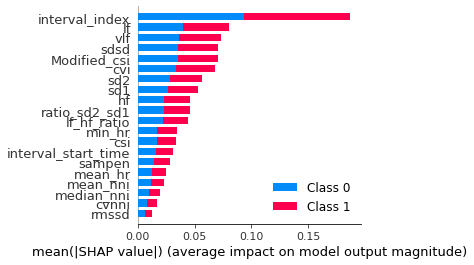

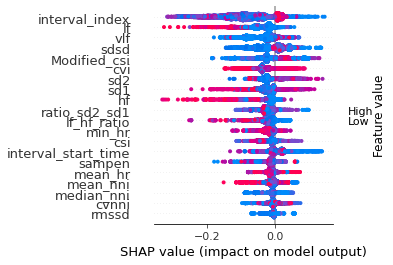

In [126]:


shap.summary_plot(shap_values_patient, X.values,
                  plot_type="bar", feature_names=X.columns,plot_size=(4,4))

shap.summary_plot(
    shap_values_patient[1], X.values, feature_names=X.columns, plot_type="dot",plot_size=(4,4))


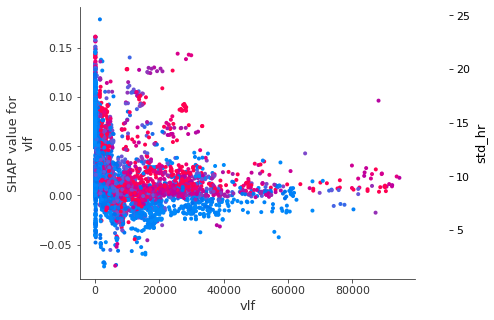

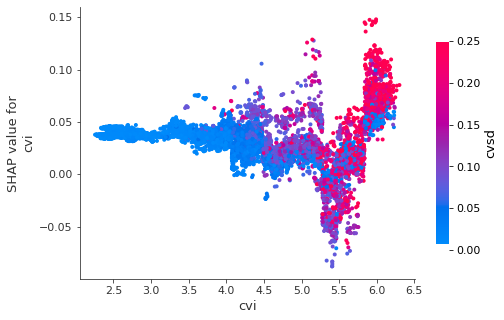

In [127]:
shap.dependence_plot(20, shap_values_patient[0], X.values, feature_names=X.columns)
shap.dependence_plot(23, shap_values_patient[0], X.values, feature_names=X.columns)

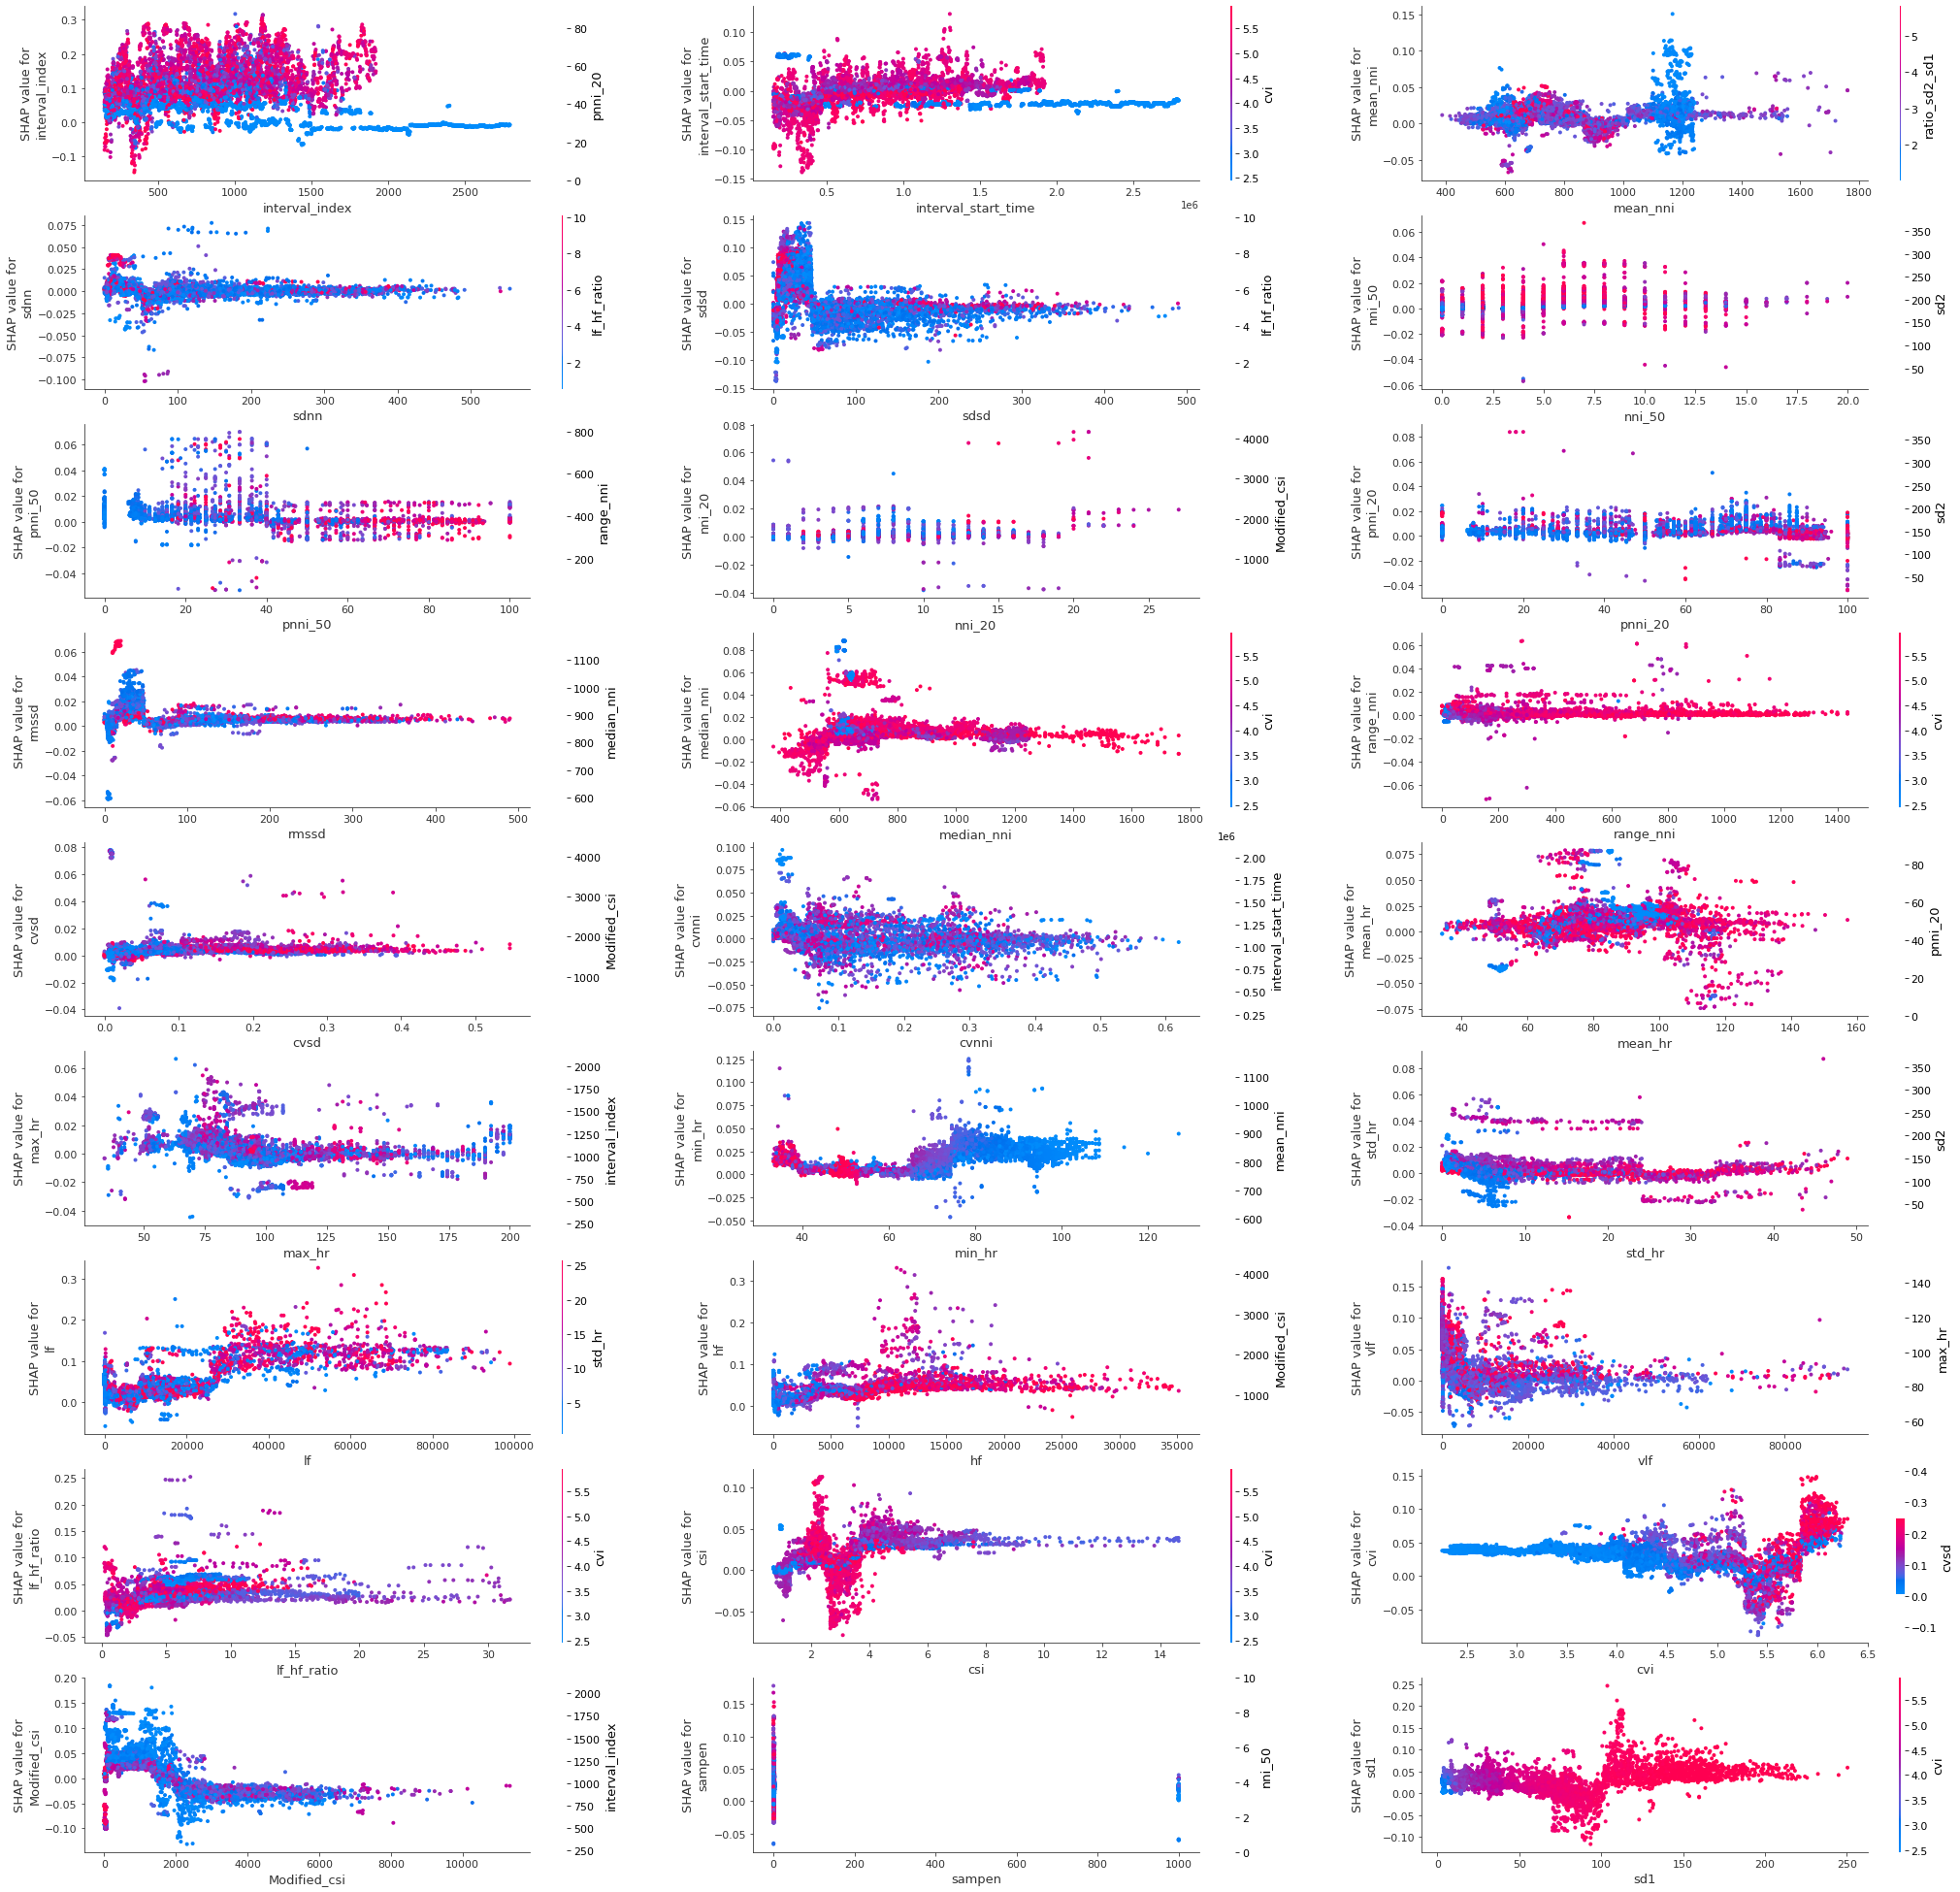

In [128]:
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(35, 35))
axes = axes.ravel()


for i in range(len(X.columns)):
    try:
        shap.dependence_plot(i, shap_values_patient[0], X.values, feature_names=X.columns,show=False,ax=axes[i])
    except:
        None
    # shap.dependence_plot(i, shap_values_patient[0], X.values, feature_names=X.columns, ax=axes[i])


# autres types de découpages

In [ ]:
# découpage par positifs négatifs:


def decoupe_crise(database):
    database[database["label"]==1]
    return db


decoupe_crise(X_test)

# Lien avec Graphana

In [129]:
columns = ['interval_index', 'interval_start_time', 'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'vlf', 'lf_hf_ratio', 'csi', 'cvi', 'Modified_csi', 'sampen', 'sd1', 'sd2', 'ratio_sd2_sd1']
model_columns = columns



def creation_database_grafana(columns,model_columns,database):
    # database_clean=database.copy()
    # if list(database.columns) != columns:
        
    #     for i in database.columns:
    #         if i not in columns:
    #             database_clean=database_clean.drop(i,axis=1)  
    # print("database clean")

    explainer_patient = shap.TreeExplainer(rf)
    shap_values_graph = explainer_patient.shap_values(database[model_columns])

    shap_columns = [0]*len(model_columns)
    for i in range(len(model_columns)):
        shap_columns[i] = "shap_values_"+columns[i]
    
    grafana = pd.DataFrame(shap_values_graph[0],columns=shap_columns)
    grafana = grafana.join(database[columns].reset_index())
    return grafana

df = creation_database_grafana(columns,model_columns,X_test)
# df.to_csv("df_grafana_1.csv")

In [113]:
def verification_db():
    #renvoi une liste vide si la db et les shap values sont cohérente
    shap_columns = [0]*len(model_columns)
    for i in range(len(model_columns)):
        shap_columns[i] = "shap_values_"+columns[i]


    explainer_patient = shap.TreeExplainer(rf)

    shap_values_test = explainer_patient.shap_values(df[model_columns].values)
    return np.where((df[shap_columns].values==shap_values_test[0])[0]==False)

In [114]:
verification_db()

(array([], dtype=int64),)